# 🚀 Hybrid Bitcoin Price Prediction Pipeline
## LightGBM vs LSTM Comparison with Exogenous Variables

### 📋 Proje Özeti
Bu notebook, Bitcoin fiyatını önümüzdeki 30 gün için tahmin eden hibrit bir makine öğrenmesi pipeline'ıdır.

**Özellikler:**
- ✅ Çoklu veri kaynağı (OHLCV, makroekonomik, teknik indikatörler, sentiment)
- ✅ Log Returns (gürültü azaltma)
- ✅ TimeSeriesSplit (veri sızıntısı önleme)
- ✅ LightGBM & LSTM karşılaştırması
- ✅ Recursive Forecasting (30 gün)
- ✅ Feature Importance analizi
- ✅ Profesyonel görselleştirme

**Modüler Yapı:**
- `data_loader.py`: Veri toplama
- `feature_engineering.py`: Özellik mühendisliği
- `preprocessing.py`: Ön işleme
- `models.py`: Model tanımları
- `forecasting.py`: Özyinelemeli tahmin
- `visualization.py`: Görselleştirme

## 📦 1. Gerekli Kütüphaneleri Yükle

In [1]:
# Sistem path ayarı (modülleri import edebilmek için)
import sys
sys.path.append('src')

# Modülleri import et
from data_loader import DataLoader
from feature_engineering import FeatureEngineer
from preprocessing import FullPipeline
from models import LightGBMModel, LSTMTrainer
from forecasting import RecursiveForecaster, ForecastAnalyzer, create_future_dates
from visualization import FinancialVisualizer

# Yardımcı kütüphaneler
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("✅ Tüm modüller başarıyla yüklendi!")

✅ Tüm modüller başarıyla yüklendi!


## 📊 2. Veri Toplama (Data Loading)

**Veri Kaynakları:**
1. **Bitcoin (BTC-USD)**: Yahoo Finance
2. **S&P 500**: Korelasyon analizi
3. **DXY**: Dolar Endeksi
4. **10Y Treasury**: Faiz oranları
5. **Fear & Greed Index**: Sentiment (placeholder)
6. **Google Trends**: Arama hacmi (placeholder)

⚠️ **ÖNEMLI NOT:** Hafta sonu problemi için forward fill kullanılır!

In [2]:
# Veri yükleyici oluştur
loader = DataLoader(
    start_date=None,  # Varsayılan: Son 3 yıl
    end_date=None,     # Varsayılan: Bugün
    fred_api_key=None  # FRED API key (opsiyonel)
)

# Tüm verileri birleştir
raw_data = loader.merge_all_data()

# İlk 5 satırı göster
print("\n📋 Raw Data (İlk 5 satır):")
raw_data.head()


🔗 TÜM VERİLER BİRLEŞTİRİLİYOR...

📊 Bitcoin verisi indiriliyor: 2023-01-28 -> 2026-01-27
✅ Bitcoin verisi yüklendi: 1095 gün
📈 S&P 500 verisi indiriliyor...
✅ S&P 500 verisi yüklendi: 750 gün
💵 DXY (Dolar Endeksi) verisi indiriliyor...
✅ DXY verisi yüklendi: 752 gün
🏦 10 Yıllık Tahvil Faizi indiriliyor...
✅ Tahvil faizi yüklendi: 750 gün
😱 Fear & Greed Index (Placeholder) oluşturuluyor...
✅ Fear & Greed placeholder: 1095 gün
🔍 Google Trends (Placeholder) oluşturuluyor...
✅ Google Trends placeholder: 1095 gün

✅ TÜM VERİLER BİRLEŞTİRİLDİ!
📊 Toplam Gün: 1095
📊 Toplam Özellik: 11

Kolonlar: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'SPX_Close', 'DXY', 'Treasury_10Y', 'Fear_Greed', 'Google_Trends']

✅ Eksik değer yok, veri seti temiz!


📋 Raw Data (İlk 5 satır):


,Date,Close,High,Low,Open,Volume,SPX_Close,DXY,Treasury_10Y,Fear_Greed,Google_Trends
0,2023-01-28,23031.089844,23165.896484,22908.845703,23079.964844,14712928379,4017.770020,102.279999,3.551,41,51
1,2023-01-29,23774.566406,23919.890625,22985.070312,23031.449219,27423687259,4017.770020,102.279999,3.551,52,86
2,2023-01-30,22840.138672,23789.347656,22657.582031,23774.648438,27205595568,4017.770020,102.279999,3.551,37,37
3,2023-01-31,23139.283203,23225.021484,22765.568359,22840.796875,22837828665,4076.600098,102.099998,3.529,26,59
4,2023-02-01,23723.769531,23764.539062,22877.750000,23137.835938,26683255504,4119.209961,101.220001,3.397,48,66


In [3]:
# Veri özeti
print("\n📊 Veri Özeti:")
print(f"Toplam Gün: {len(raw_data)}")
print(f"Başlangıç Tarihi: {raw_data['Date'].min()}")
print(f"Bitiş Tarihi: {raw_data['Date'].max()}")
print(f"\nKolonlar ({len(raw_data.columns)}):")
print(raw_data.columns.tolist())


📊 Veri Özeti:
Toplam Gün: 1095
Başlangıç Tarihi: 2023-01-28 00:00:00
Bitiş Tarihi: 2026-01-26 00:00:00

Kolonlar (11):
['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'SPX_Close', 'DXY', 'Treasury_10Y', 'Fear_Greed', 'Google_Trends']


## 🔧 3. Feature Engineering

**Oluşturulacak Özellikler:**
1. **Teknik İndikatörler**: RSI, MACD, Bollinger Bands, ATR, VWAP, EMA
2. **Lag Features**: 30 günlük geçmiş fiyat bilgisi
3. **Rolling Statistics**: Hareketli ortalamalar, volatilite
4. **Cyclical Features**: Sin/Cos ile zaman kodlaması
5. **Momentum Features**: ROC, Price Position
6. **Volume Features**: Hacim analizleri
7. **Macro Interactions**: SPX-BTC, DXY-BTC ilişkileri

In [4]:
# Feature Engineer oluştur
engineer = FeatureEngineer(raw_data)

# Tüm özellikleri oluştur
featured_data = engineer.create_all_features(n_lags=30)

# Feature isimleri
feature_names = engineer.get_feature_names()
print(f"\n🎯 Toplam Feature Sayısı: {len(feature_names)}")
print(f"\n📋 Bazı Özellikler:")
print(feature_names[:30])


🔧 FEATURE ENGINEERING BAŞLIYOR...

📈 Teknik indikatörler ekleniyor...
✅ 11 teknik indikatör eklendi
🔙 30 günlük lag features ekleniyor...
✅ 33 lag feature eklendi
📊 Rolling statistics ekleniyor...
✅ 9 rolling feature eklendi
🔄 Cyclical time features ekleniyor...
✅ Cyclical time features eklendi (Sin/Cos)
⚡ Momentum features ekleniyor...
✅ Momentum features eklendi
📊 Volume features ekleniyor...
✅ Volume features eklendi
🌍 Macro interaction features ekleniyor...
✅ Macro interaction features eklendi

------------------------------------------------------------
🔍 Eksik Değer Kontrolü...
------------------------------------------------------------
✅ 199 satır (başlangıç NaN'ları) silindi
📊 Kalan satır sayısı: 896
📊 Toplam özellik sayısı: 91

✅ FEATURE ENGINEERING TAMAMLANDI!


🎯 Toplam Feature Sayısı: 85

📋 Bazı Özellikler:
['SPX_Close', 'DXY', 'Treasury_10Y', 'Fear_Greed', 'Google_Trends', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low', 'BB_Mid', 'BB_Width', 'ATR', 'VWAP'

In [5]:
# Oluşturulan veriyi kaydet
featured_data.to_csv('data/featured_data.csv', index=False)
print("✅ Featured data kaydedildi: data/featured_data.csv")

✅ Featured data kaydedildi: data/featured_data.csv


## 🔬 4. Data Preprocessing

**İşlemler:**
1. **Log Returns**: Hedef değişken olarak kullanılır (fiyat gürültüsünü azaltır)
2. **TimeSeriesSplit**: Veri sızıntısı engelleme (gelecek verisi eğitimde kullanılmaz)
3. **Scaling**: MinMaxScaler (0-1 arası normalize)
4. **LSTM Sequences**: 60 günlük pencereler oluşturma

In [6]:
# Pipeline oluştur
pipeline = FullPipeline(featured_data, target_col='Close')

# LightGBM için preprocessing
print("\n" + "="*70)
print("🔧 LIGHTGBM PREPROCESSING")
print("="*70)

lgb_data = pipeline.run_lightgbm_pipeline(test_size=0.2, scaler_type='minmax')

print(f"\n✅ LightGBM Veri Hazır:")
print(f"   X_train: {lgb_data['X_train'].shape}")
print(f"   X_test: {lgb_data['X_test'].shape}")
print(f"   y_train: {lgb_data['y_train'].shape}")
print(f"   y_test: {lgb_data['y_test'].shape}")


🔧 LIGHTGBM PREPROCESSING

🔧 LIGHTGBM PREPROCESSING PIPELINE
📉 Log Returns hesaplanıyor...
✅ Log Returns oluşturuldu
   Mean: 0.001237
   Std: 0.024402

📊 X ve y ayrılıyor...
✅ X shape: (895, 81)
✅ y shape: (895,)
✅ Feature sayısı: 81

✂️ Train-Test Split (Zaman Serisi)...
✅ Train: 716 örneklem (80%)
✅ Test: 179 örneklem (20%)

⚠️ VERİ SIZINTISI ENGELLEME:
   - Train verisi: İlk 716 gün (GEÇMIŞ)
   - Test verisi: Son 179 gün (GELECEK)
   - Gelecek verisi eğitimde kullanılmadı! ✅

📏 Feature Scaling (minmax)...
✅ Scaling tamamlandı
   Scaler: minmax
   Train Min-Max: [0.0000, 1.0000]
   Test Min-Max: [-0.2258, 1.2585]

⚠️ VERİ SIZINTISI ENGELLEME:
   - Scaler SADECE train verisi ile fit edildi ✅
   - Test verisi fit sırasında kullanılmadı ✅

✅ LightGBM preprocessing tamamlandı!

✅ LightGBM Veri Hazır:
   X_train: (716, 81)
   X_test: (179, 81)
   y_train: (716,)
   y_test: (179,)


In [7]:
# LSTM için preprocessing
print("\n" + "="*70)
print("🔧 LSTM PREPROCESSING")
print("="*70)

lstm_data = pipeline.run_lstm_pipeline(test_size=0.2, seq_length=60)

print(f"\n✅ LSTM Veri Hazır:")
print(f"   X_train: {lstm_data['X_train'].shape} (samples, timesteps, features)")
print(f"   X_test: {lstm_data['X_test'].shape}")
print(f"   y_train: {lstm_data['y_train'].shape}")
print(f"   y_test: {lstm_data['y_test'].shape}")


🔧 LSTM PREPROCESSING

🔧 LSTM PREPROCESSING PIPELINE
📉 Log Returns hesaplanıyor...
✅ Log Returns oluşturuldu
   Mean: 0.001257
   Std: 0.024408

📊 X ve y ayrılıyor...
✅ X shape: (894, 81)
✅ y shape: (894,)
✅ Feature sayısı: 81

✂️ Train-Test Split (Zaman Serisi)...
✅ Train: 715 örneklem (80%)
✅ Test: 179 örneklem (20%)

⚠️ VERİ SIZINTISI ENGELLEME:
   - Train verisi: İlk 715 gün (GEÇMIŞ)
   - Test verisi: Son 179 gün (GELECEK)
   - Gelecek verisi eğitimde kullanılmadı! ✅

📏 Feature Scaling (minmax)...
✅ Scaling tamamlandı
   Scaler: minmax
   Train Min-Max: [0.0000, 1.0000]
   Test Min-Max: [-0.2258, 1.2585]

⚠️ VERİ SIZINTISI ENGELLEME:
   - Scaler SADECE train verisi ile fit edildi ✅
   - Test verisi fit sırasında kullanılmadı ✅

🎯 Target Scaling...
✅ Target scaling tamamlandı
   Train Min-Max: [0.0000, 1.0000]

🔗 LSTM Sequences oluşturuluyor (seq_length=60)...
✅ Sequences oluşturuldu
   X shape: (655, 60, 81) (samples, timesteps, features)
   y shape: (655,)

🔗 LSTM Sequences oluştu

## 🤖 5. Model Training - LightGBM

**LightGBM Avantajları:**
- ⚡ Hızlı eğitim
- 📊 Feature importance analizi
- 🎯 Missing value handling
- 🔥 Yüksek performans

In [8]:
# LightGBM parametreleri
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_estimators': 1000,
    'random_state': 42
}

# Model oluştur ve eğit
lgb_model = LightGBMModel(params=lgb_params)
lgb_model.train(
    lgb_data['X_train'], 
    lgb_data['y_train'],
    feature_names=lgb_data['feature_names']
)


🚀 LightGBM Eğitimi Başlıyor...
✅ Eğitim tamamlandı


In [9]:
# Test set üzerinde değerlendirme
lgb_metrics = lgb_model.evaluate(lgb_data['X_test'], lgb_data['y_test'])


📊 LightGBM Performans Metrikleri:
   RMSE    : 0.001986
   MAE     : 0.001218
   R2      : 0.989613
   MAPE    : 19.916612


In [10]:
# Feature Importance analizi
feature_importance = lgb_model.get_feature_importance(top_n=20)
print("\n🎯 En Önemli 20 Feature:")
print(feature_importance)


🎯 En Önemli 20 Feature:
            Feature  Importance
65            ROC_1        3341
73  Volume_Ratio_30        1380
69   Price_Position        1248
72   Volume_Ratio_7        1058
51     Volatility_7         794
52         Return_7         751
8         MACD_Diff         741
54    Volatility_14         623
74    Volume_Change         617
47     Volume_Lag_3         609
75       SPX_Return         586
58        Return_30         496
3        Fear_Greed         455
49    Volume_Lag_14         455
55        Return_14         450
4     Google_Trends         435
80  Fear_Greed_MA_7         414
5               RSI         400
12         BB_Width         396
57    Volatility_30         391


## 🧠 6. Model Training - LSTM

**LSTM Avantajları:**
- 📈 Sequence learning
- 🔄 Uzun vadeli bağımlılıklar
- 🎯 Temporal patterns
- 🌊 Zaman serisi için ideal

In [11]:
# LSTM parametreleri
input_size = lstm_data['X_train'].shape[2]  # Feature sayısı

lstm_trainer = LSTMTrainer(
    input_size=input_size,
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    learning_rate=0.001
)

# Validation split (eğitim setinin %20'si)
val_split = int(len(lstm_data['X_train']) * 0.8)
X_train_lstm = lstm_data['X_train'][:val_split]
y_train_lstm = lstm_data['y_train'][:val_split]
X_val_lstm = lstm_data['X_train'][val_split:]
y_val_lstm = lstm_data['y_train'][val_split:]

# Model eğitimi
lstm_trainer.train(
    X_train_lstm, y_train_lstm,
    X_val=X_val_lstm, y_val=y_val_lstm,
    epochs=100,
    batch_size=32,
    patience=15
)


🖥️ Device: cpu

🚀 LSTM Eğitimi Başlıyor...
   Epochs: 100, Batch Size: 32
   Epoch 10/100 - Train Loss: 0.020397, Val Loss: 0.009598
   Epoch 20/100 - Train Loss: 0.017572, Val Loss: 0.009707

⚠️ Early Stopping at epoch 29
✅ LSTM eğitimi tamamlandı


In [12]:
# Test set üzerinde değerlendirme
lstm_metrics = lstm_trainer.evaluate(lstm_data['X_test'], lstm_data['y_test'])


📊 LSTM Performans Metrikleri:
   RMSE    : 0.113820
   MAE     : 0.086685
   R2      : -0.243581
   MAPE    : 27.677696


## 📊 7. Model Karşılaştırması ve Görselleştirme

✅ Grafik kaydedildi: metrics_comparison.png


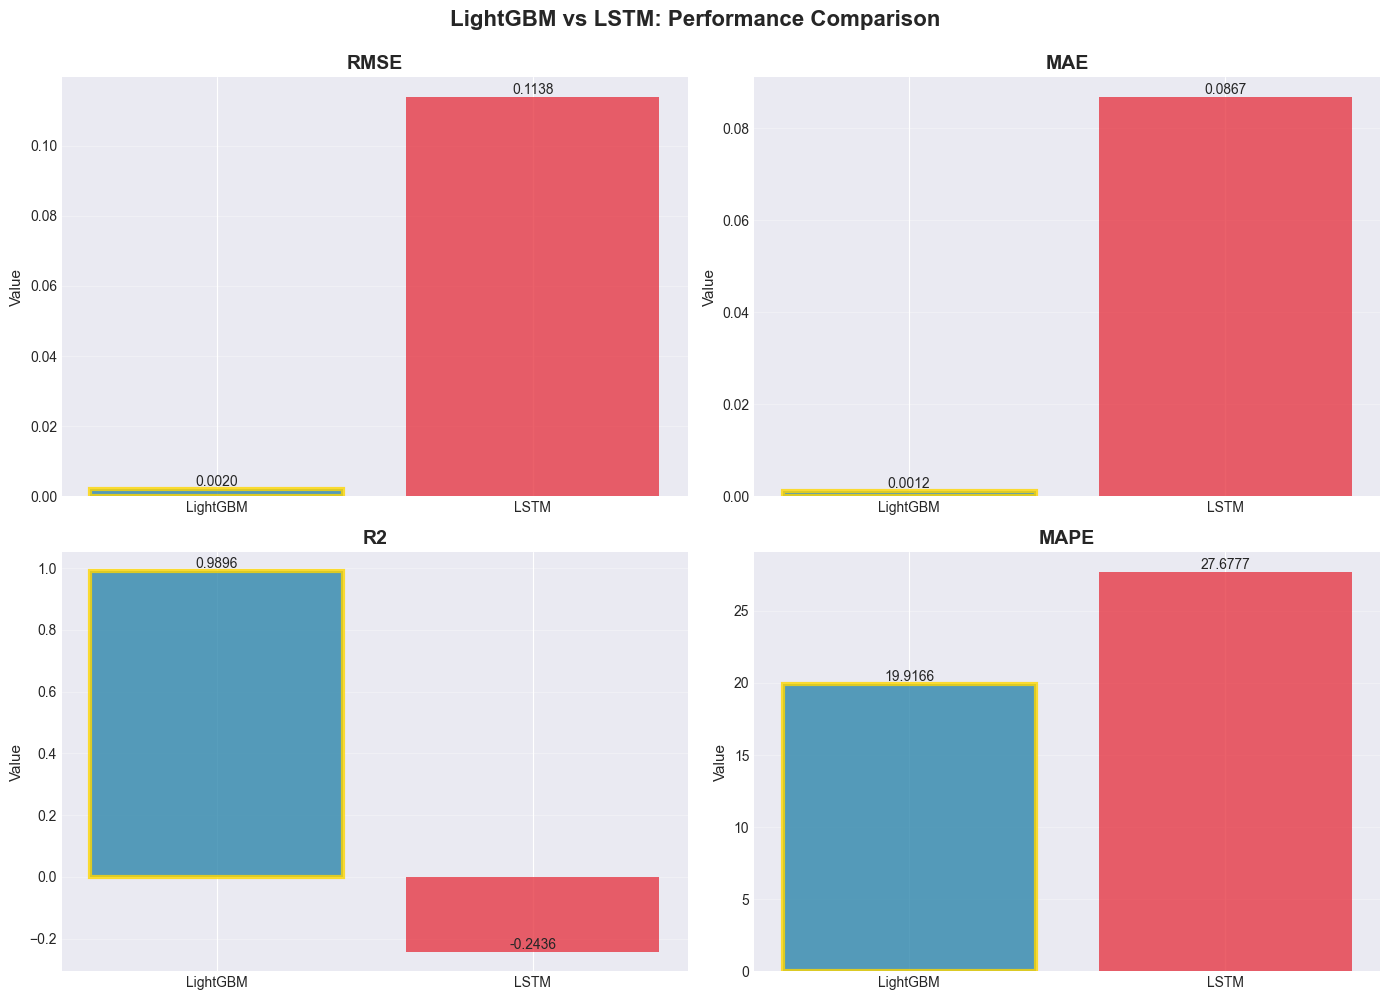

In [13]:
# Görselleştirici oluştur
viz = FinancialVisualizer(figsize=(14, 8), save_dir='outputs')

# Metrik karşılaştırması
viz.plot_metrics_comparison(
    lgb_metrics, 
    lstm_metrics,
    title='LightGBM vs LSTM: Performance Comparison',
    save_path='metrics_comparison.png'
)

✅ Grafik kaydedildi: feature_importance.png


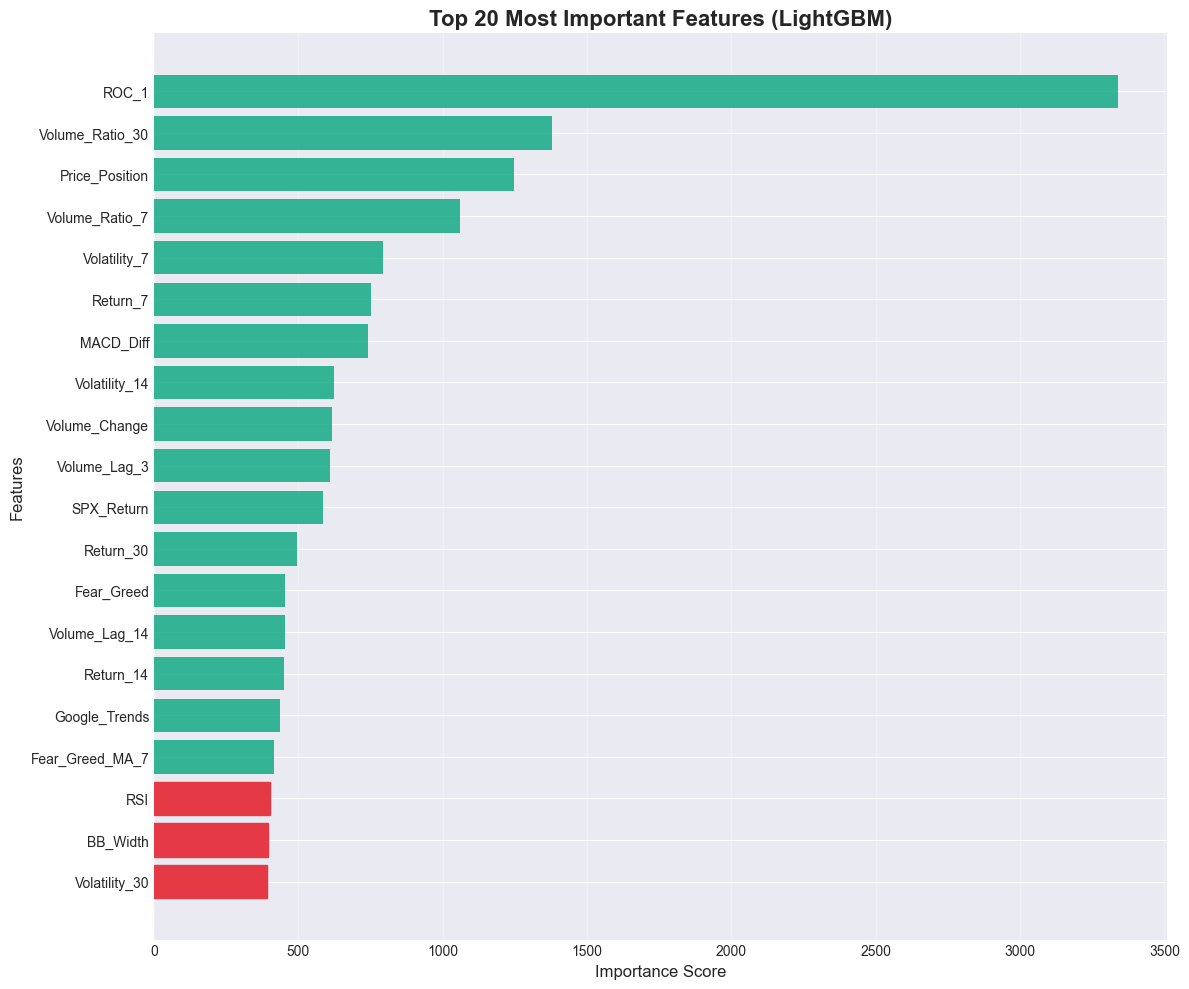

In [14]:
# Feature Importance grafiği (LightGBM)
viz.plot_feature_importance(
    feature_importance,
    top_n=20,
    title='Top 20 Most Important Features (LightGBM)',
    save_path='feature_importance.png'
)

✅ Grafik kaydedildi: lstm_loss_curve.png


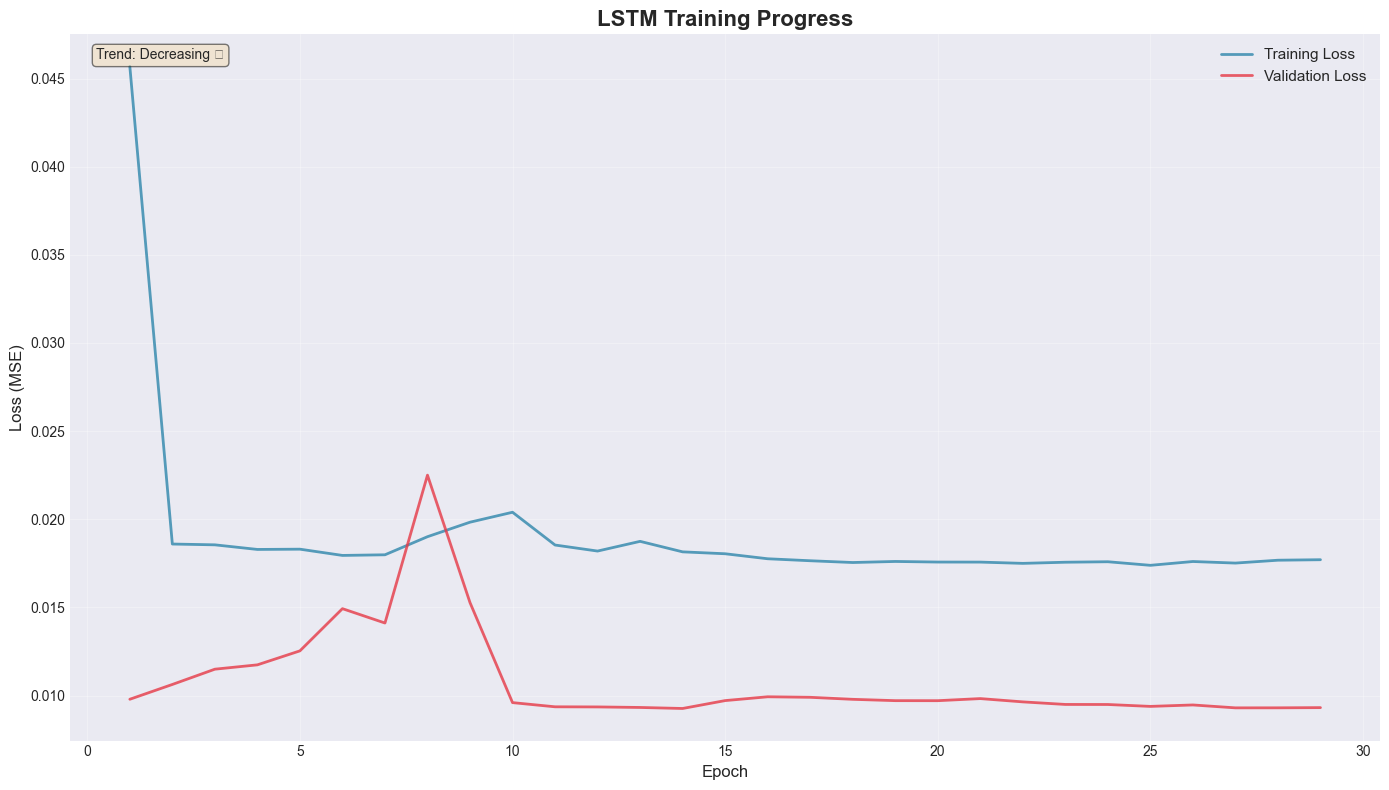

In [15]:
# LSTM Loss Curve
viz.plot_lstm_loss_curve(
    lstm_trainer.train_losses,
    lstm_trainer.val_losses,
    title='LSTM Training Progress',
    save_path='lstm_loss_curve.png'
)

✅ Grafik kaydedildi: lgb_test_predictions.png


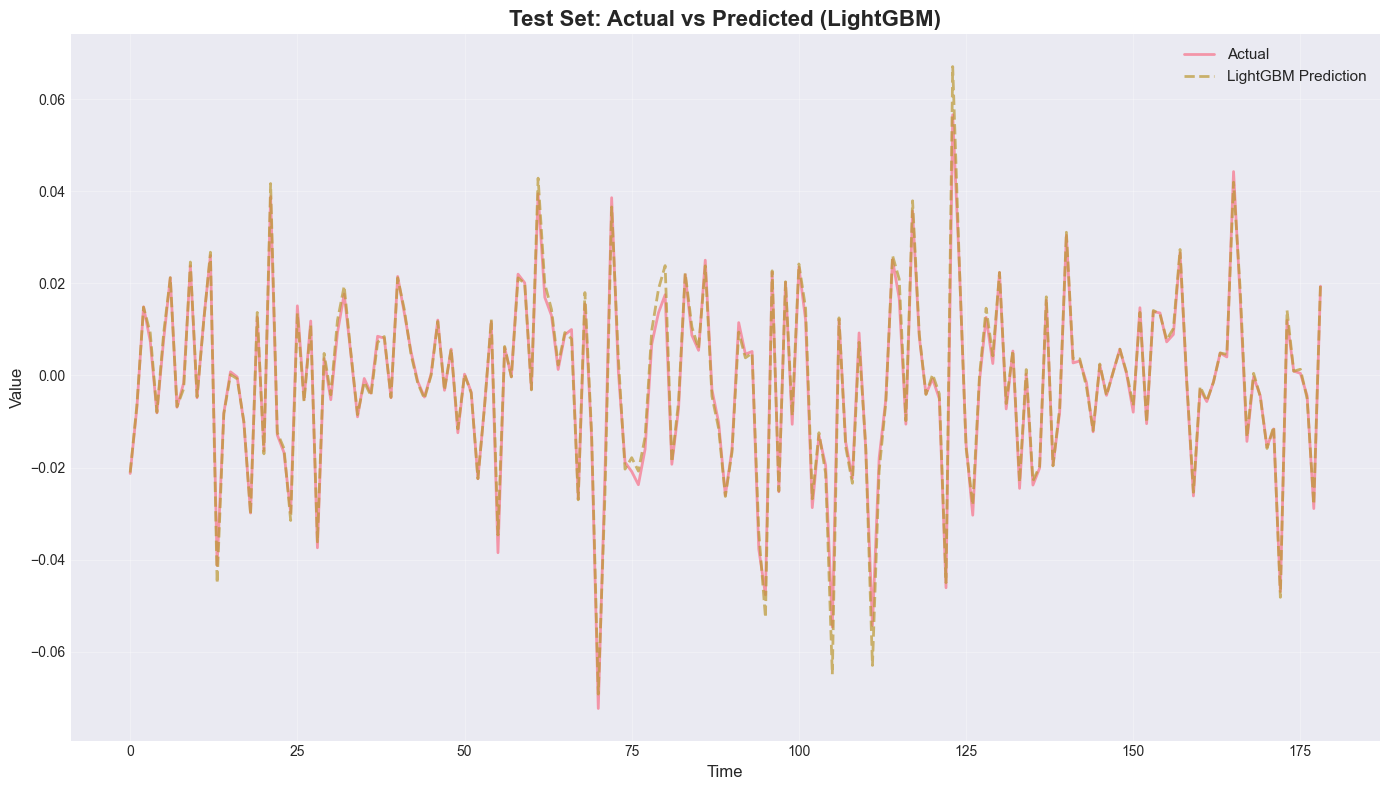

In [16]:
# Test set tahminleri
lgb_test_pred = lgb_model.predict(lgb_data['X_test'])
lstm_test_pred = lstm_trainer.predict(lstm_data['X_test'])

# Actual vs Predicted (LightGBM)
viz.plot_actual_vs_predicted(
    lgb_data['y_test'],
    lgb_test_pred,
    title='Test Set: Actual vs Predicted (LightGBM)',
    model_name='LightGBM',
    save_path='lgb_test_predictions.png'
)

✅ Grafik kaydedildi: lstm_test_predictions.png


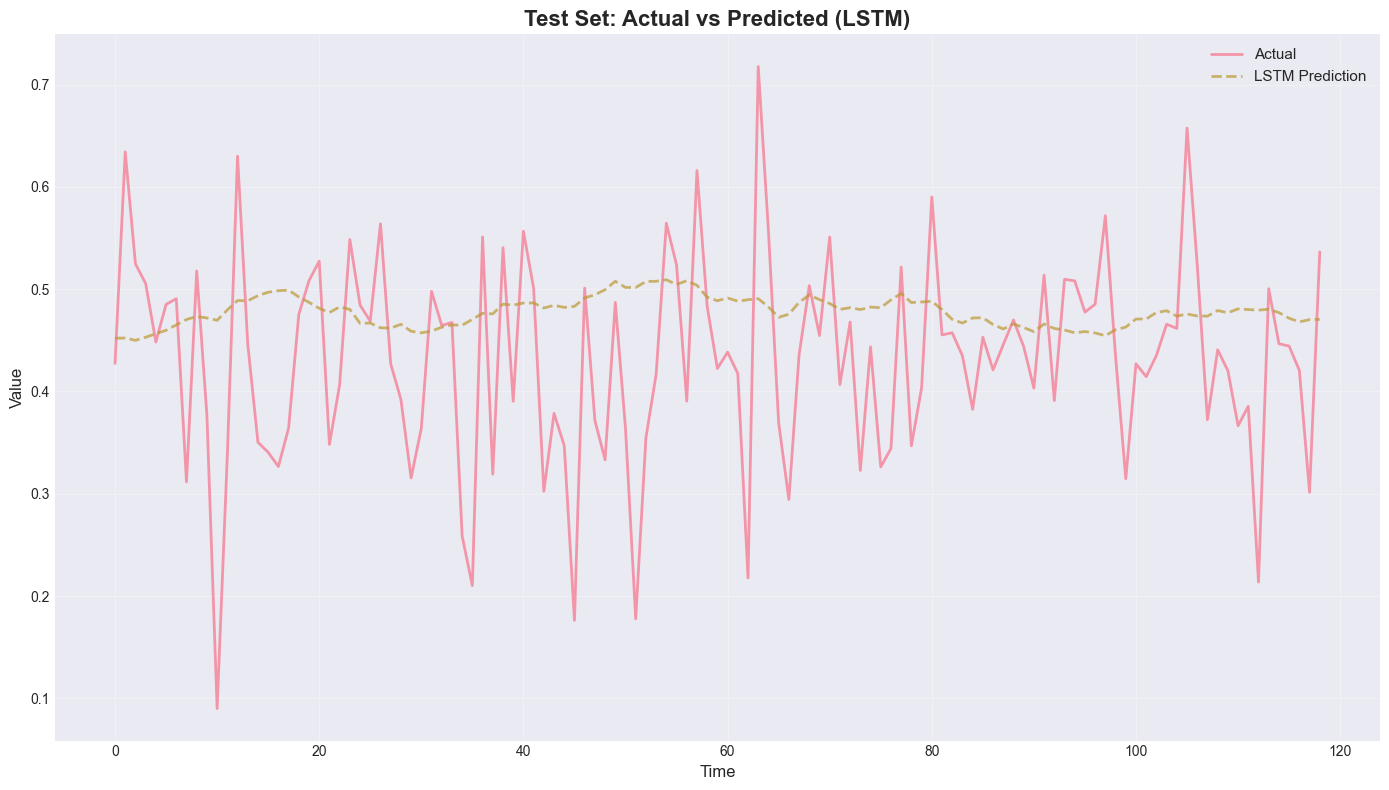

In [17]:
# Actual vs Predicted (LSTM)
viz.plot_actual_vs_predicted(
    lstm_data['y_test'],
    lstm_test_pred,
    title='Test Set: Actual vs Predicted (LSTM)',
    model_name='LSTM',
    save_path='lstm_test_predictions.png'
)

✅ Grafik kaydedildi: lgb_residuals.png


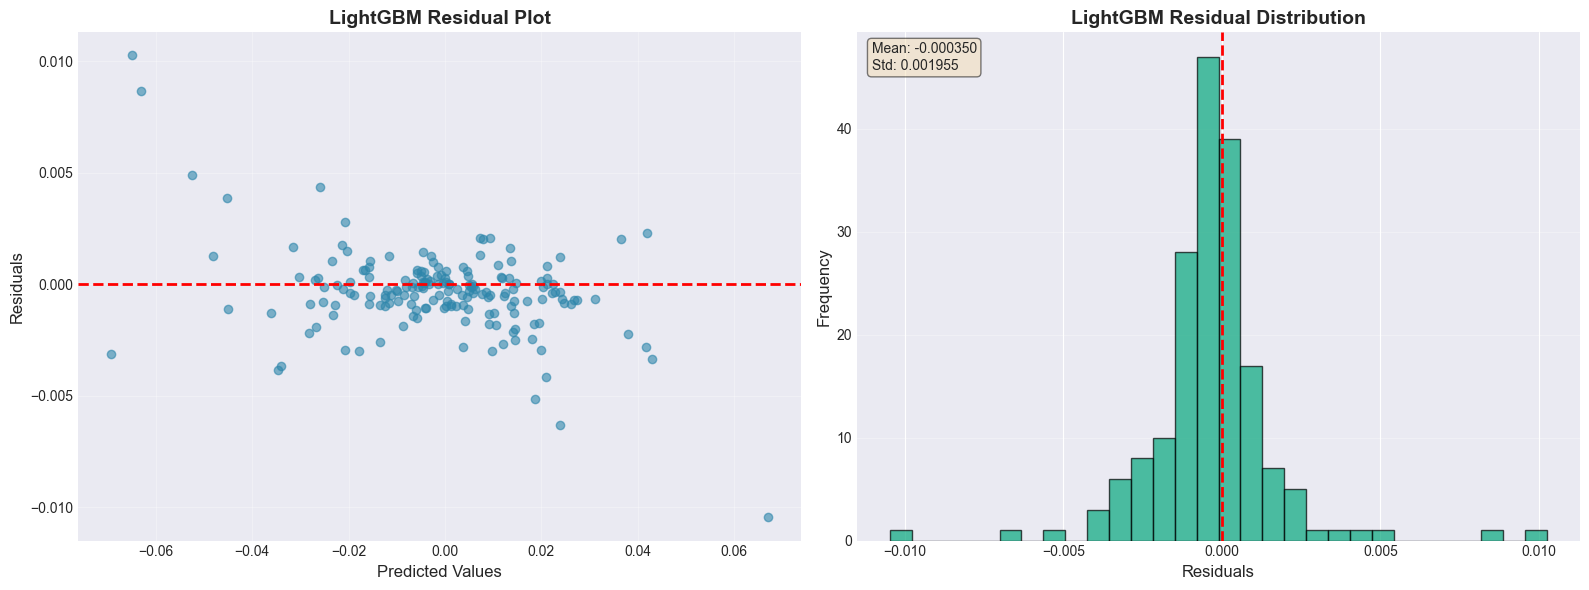

In [18]:
# Residual Analysis
viz.plot_residuals(
    lgb_data['y_test'],
    lgb_test_pred,
    model_name='LightGBM',
    save_path='lgb_residuals.png'
)

## 🔮 8. Recursive Forecasting (30 Gün)

**Özyinelemeli Tahmin Süreci:**
1. t+1'i tahmin et
2. Bu tahmini veri setine ekle ("gerçekleşmiş" gibi)
3. t+2'yi tahmin et
4. Bu döngüyü 30 adım tekrarla

⚠️ **UYARI:** Hata birikimi riski! İlk günlerdeki hatalar sonraki günleri etkiler.

In [19]:
# Son bilinen fiyat
last_price = lgb_data['original_df']['Close'].iloc[-1]
print(f"Son Bilinen Bitcoin Fiyatı: ${last_price:,.2f}")

# Son bilinen tarih
last_date = lgb_data['original_df']['Date'].iloc[-1]
print(f"Son Tarih: {last_date}")

Son Bilinen Bitcoin Fiyatı: $88,267.14
Son Tarih: 2026-01-26 00:00:00


In [20]:
# LightGBM ile 30 günlük tahmin
lgb_forecaster = RecursiveForecaster(
    model=lgb_model,
    preprocessor=lgb_data['preprocessor'],
    feature_names=lgb_data['feature_names']
)

# Son günün features'ı
X_last_lgb = lgb_data['X_test'][-1]

lgb_forecast = lgb_forecaster.forecast_lightgbm(
    X_last=X_last_lgb,
    n_steps=30,
    last_price=last_price
)


🔮 LightGBM Recursive Forecasting (30 gün)...
   ✅ 10 gün tamamlandı
   ✅ 20 gün tamamlandı
   ✅ 30 gün tamamlandı
✅ Tahmin tamamlandı!


In [26]:
# LSTM ile 30 günlük tahmin
lstm_forecaster = RecursiveForecaster(
    model=lstm_trainer,
    preprocessor=lstm_data['preprocessor'],
    feature_names=lstm_data['feature_names']
)

# Son sequence
X_last_lstm = lstm_data['X_test'][-1]

lstm_forecast = lstm_forecaster.forecast_lstm(
    X_last_sequence=X_last_lstm,
    n_steps=30,
    last_price=last_price,
    seq_length=lstm_data['seq_length']
)


🔮 LSTM Recursive Forecasting (30 gün)...
   ✅ 10 gün tamamlandı
   ✅ 20 gün tamamlandı
   ✅ 30 gün tamamlandı
✅ LSTM tahmin tamamlandı!


In [25]:
# Module değişikliklerini yeniden yükle
import importlib
import sys

# forecasting modülünü cache'ten kaldır ve yeniden yükle
if 'src.forecasting' in sys.modules:
    del sys.modules['src.forecasting']

from src.forecasting import RecursiveForecaster

# Forecaster'ları tekrar oluştur
lgb_forecaster = RecursiveForecaster(
    model=lgb_model,
    preprocessor=lgb_data['preprocessor'],
    feature_names=lgb_data['feature_names']
)

lstm_forecaster = RecursiveForecaster(
    model=lstm_trainer,
    preprocessor=lstm_data['preprocessor'],
    feature_names=lstm_data['feature_names']
)
print("✅ Modüller yeniden yüklendi!")

✅ Modüller yeniden yüklendi!


In [27]:
# Gelecek tarihleri oluştur
future_dates = create_future_dates(last_date, 30)

# LightGBM tahmin analizi
lgb_analyzer = ForecastAnalyzer(lgb_forecast, dates=future_dates)
lgb_analyzer.print_summary()

# Tahminleri DataFrame'e çevir
lgb_forecast_df = lgb_analyzer.get_forecast_dataframe()
lgb_forecast_df.to_csv('outputs/lgb_30day_forecast.csv', index=False)
print("\n✅ LightGBM tahminler kaydedildi: outputs/lgb_30day_forecast.csv")


📊 FORECAST SUMMARY

💰 Fiyat Tahminleri:
   Başlangıç: $90,053.82
   Bitiş: $161,024.49
   Min: $90,053.82
   Max: $161,024.49
   Ortalama: $122,239.19
   Değişim: $70,970.67 (78.81%)
   Volatilite: $21,138.77

📈 Log Return İstatistikleri:
   Ortalama: 0.020040
   Std: 0.000000
   Min: 0.020040
   Max: 0.020040


✅ LightGBM tahminler kaydedildi: outputs/lgb_30day_forecast.csv


In [28]:
# LSTM tahmin analizi
lstm_analyzer = ForecastAnalyzer(lstm_forecast, dates=future_dates)
lstm_analyzer.print_summary()

# Tahminleri DataFrame'e çevir
lstm_forecast_df = lstm_analyzer.get_forecast_dataframe()
lstm_forecast_df.to_csv('outputs/lstm_30day_forecast.csv', index=False)
print("\n✅ LSTM tahminler kaydedildi: outputs/lstm_30day_forecast.csv")


📊 FORECAST SUMMARY

💰 Fiyat Tahminleri:
   Başlangıç: $88,784.20
   Bitiş: $104,188.31
   Min: $88,784.20
   Max: $104,188.31
   Ortalama: $96,315.66
   Değişim: $15,404.12 (17.35%)
   Volatilite: $4,584.76

📈 Log Return İstatistikleri:
   Ortalama: 0.005528
   Std: 0.000088
   Min: 0.005488
   Max: 0.005841


✅ LSTM tahminler kaydedildi: outputs/lstm_30day_forecast.csv


## 📈 9. Gelecek Tahminlerini Görselleştir

✅ Grafik kaydedildi: lgb_30day_forecast.png


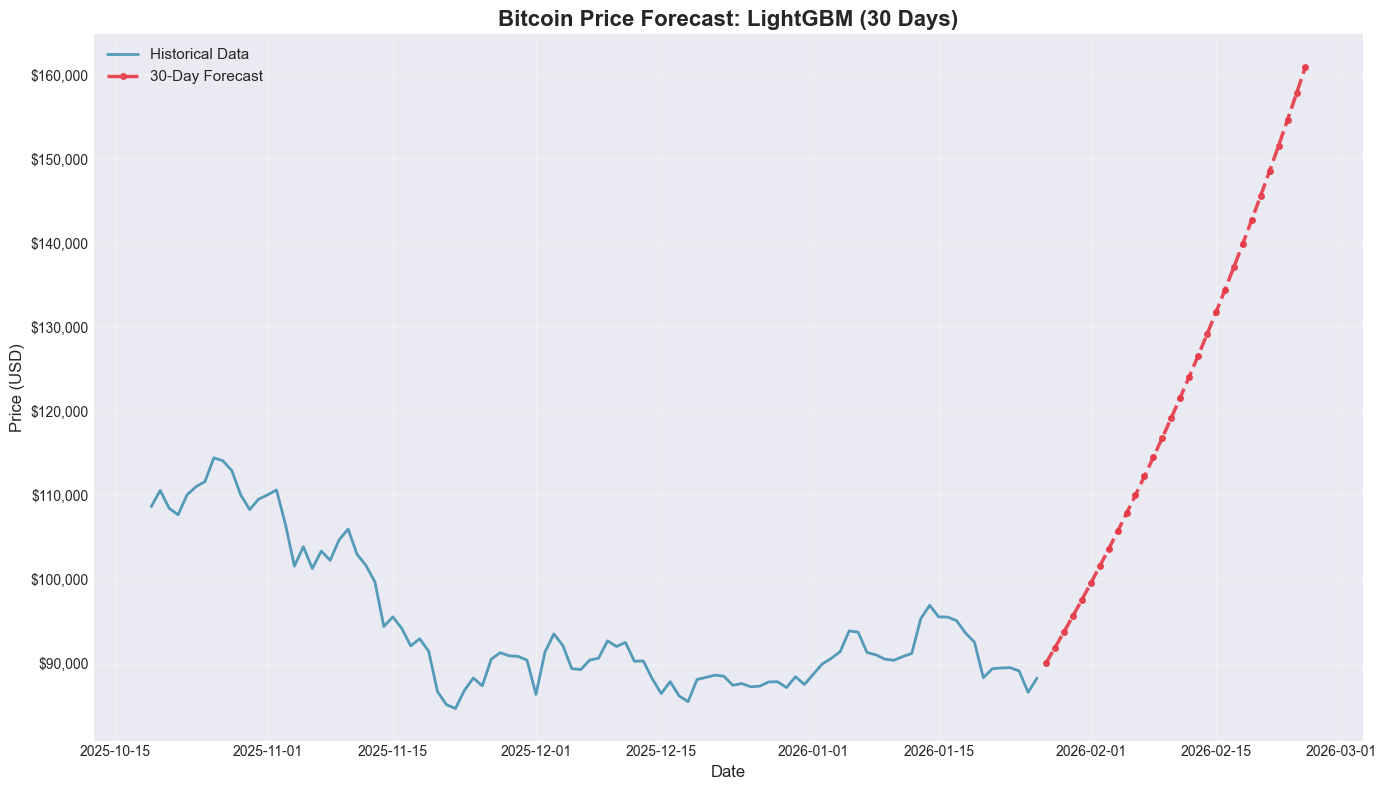

In [29]:
# Geçmiş fiyatlar (son 100 gün)
historical_prices = lgb_data['original_df']['Close'].tail(100).values
historical_dates = lgb_data['original_df']['Date'].tail(100).values

# LightGBM forecast grafiği
viz.plot_price_predictions(
    actual_prices=historical_prices,
    pred_prices=lgb_forecast['prices'],
    actual_dates=historical_dates,
    pred_dates=future_dates,
    title='Bitcoin Price Forecast: LightGBM (30 Days)',
    save_path='lgb_30day_forecast.png'
)

✅ Grafik kaydedildi: lstm_30day_forecast.png


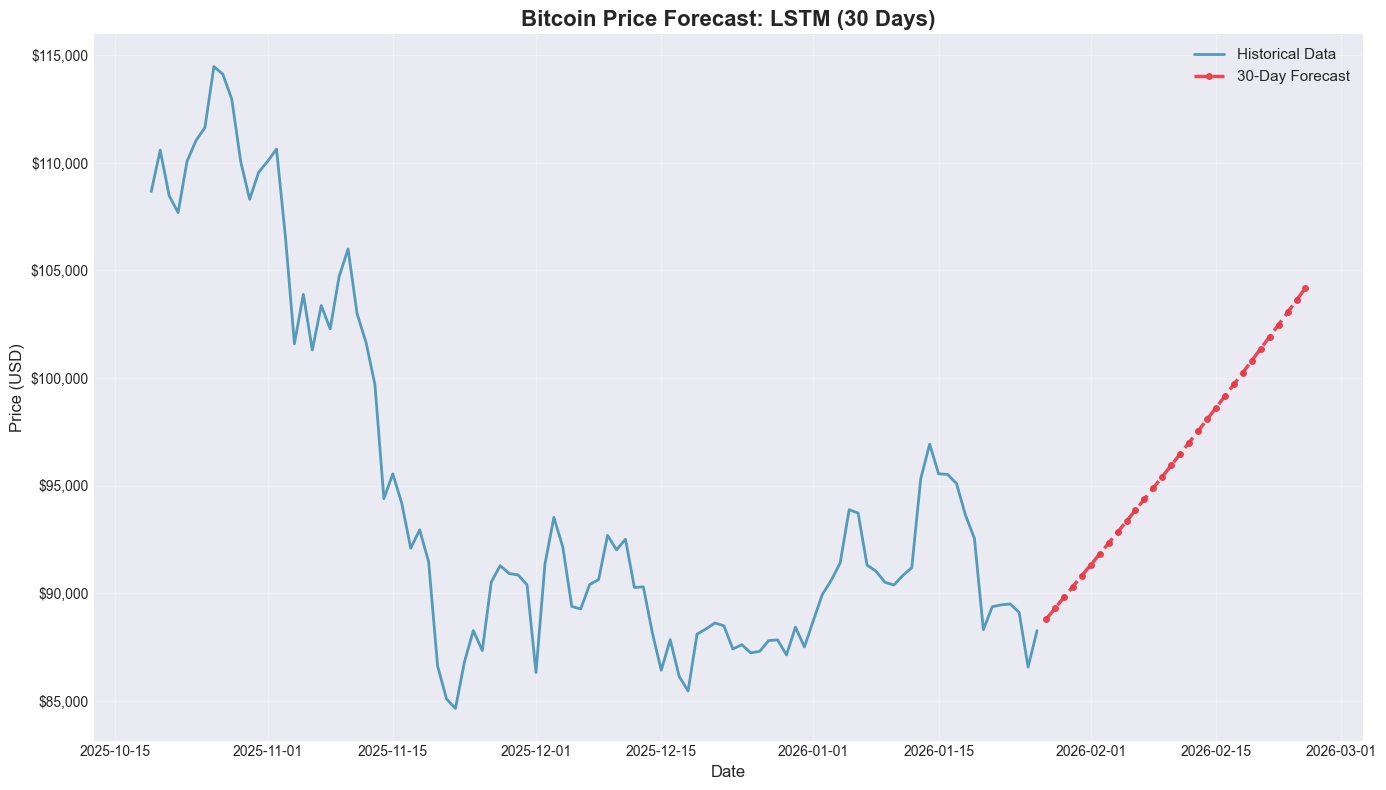

In [30]:
# LSTM forecast grafiği
viz.plot_price_predictions(
    actual_prices=historical_prices,
    pred_prices=lstm_forecast['prices'],
    actual_dates=historical_dates,
    pred_dates=future_dates,
    title='Bitcoin Price Forecast: LSTM (30 Days)',
    save_path='lstm_30day_forecast.png'
)

✅ Grafik kaydedildi: lgb_forecast_confidence.png


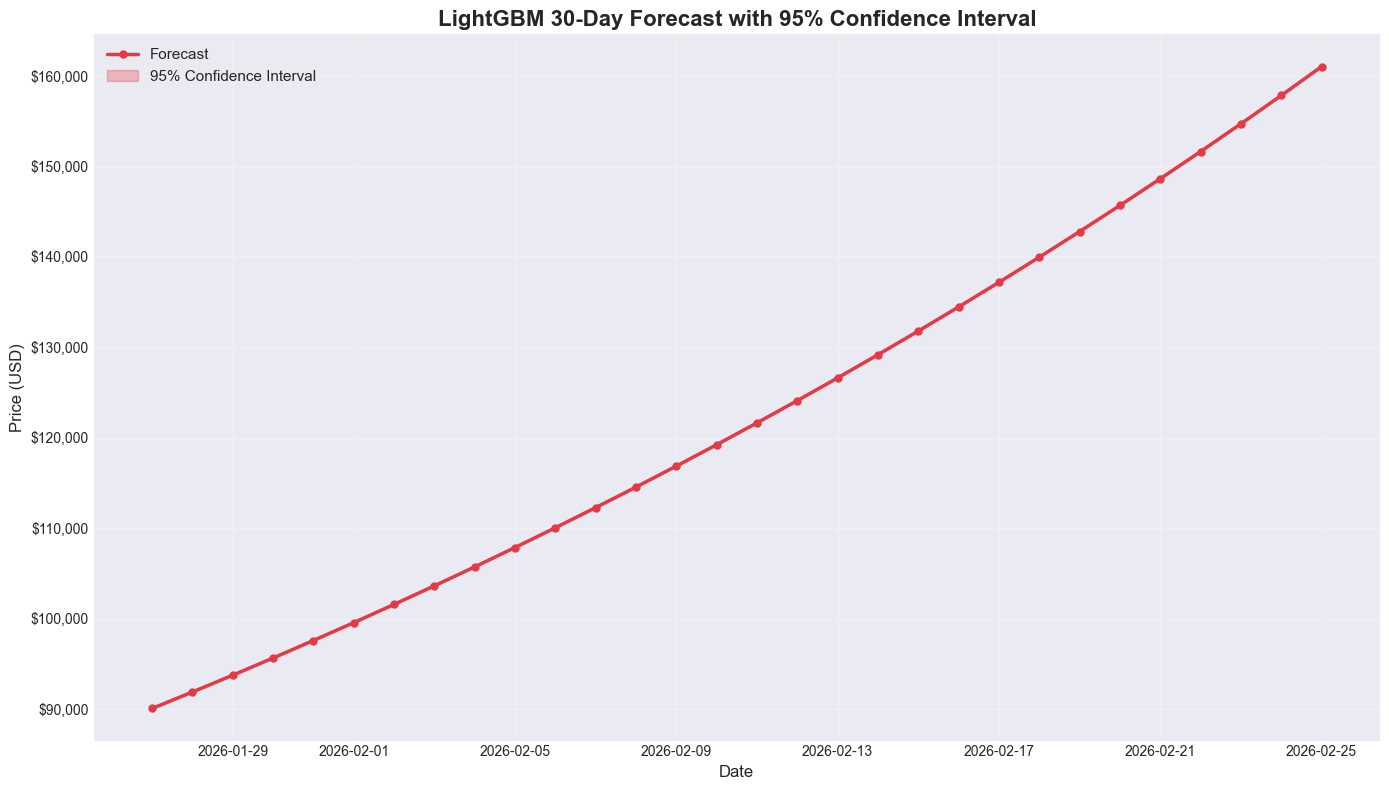

In [31]:
# Güven aralıklı grafik (LightGBM)
lgb_ci = lgb_analyzer.calculate_confidence_intervals(std_multiplier=1.96)

viz.plot_forecast_with_confidence(
    forecast_prices=lgb_forecast['prices'],
    upper_bound=lgb_ci['upper'],
    lower_bound=lgb_ci['lower'],
    dates=future_dates,
    title='LightGBM 30-Day Forecast with 95% Confidence Interval',
    save_path='lgb_forecast_confidence.png'
)

## 📊 10. Final Karşılaştırma ve Özet

In [32]:
# Her iki modelin tahminlerini karşılaştır
comparison_df = pd.DataFrame({
    'Date': future_dates,
    'LightGBM_Price': lgb_forecast['prices'],
    'LSTM_Price': lstm_forecast['prices'],
    'Difference': lgb_forecast['prices'] - lstm_forecast['prices'],
    'Difference_Pct': ((lgb_forecast['prices'] - lstm_forecast['prices']) / lstm_forecast['prices']) * 100
})

print("\n📊 Model Tahminleri Karşılaştırması:")
print(comparison_df)

comparison_df.to_csv('outputs/model_comparison.csv', index=False)
print("\n✅ Karşılaştırma kaydedildi: outputs/model_comparison.csv")


📊 Model Tahminleri Karşılaştırması:
         Date  LightGBM_Price     LSTM_Price    Difference  Difference_Pct
0  2026-01-27    90053.822976   88784.197940   1269.625036        1.430012
1  2026-01-28    91876.670924   89299.881082   2576.789842        2.885547
2  2026-01-29    93736.416524   89809.844221   3926.572303        4.372096
3  2026-01-30    95633.806650   90314.869480   5318.937170        5.889326
4  2026-01-31    97569.603293   90817.339837   6752.263456        7.434994
5  2026-02-01    99544.583869   91319.481360   8225.102508        9.006953
6  2026-02-02   101559.541529   91822.847074   9736.694454       10.603782
7  2026-02-03   103615.285480   92328.357116  11286.928364       12.224769
8  2026-02-04   105712.641308   92836.490410  12876.150898       13.869709
9  2026-02-05   107852.451312   93347.463103  14504.988209       15.538706
10 2026-02-06   110035.574838   93861.357381  16174.217458       17.232030
11 2026-02-07   112262.888629   94378.191104  17884.697525     

In [33]:
# Final özet
print("\n" + "="*70)
print("🎯 FINAL ÖZET")
print("="*70)

print("\n📊 Model Performansları (Test Set):")
print("\nLightGBM:")
for metric, value in lgb_metrics.items():
    print(f"  {metric:8s}: {value:.6f}")

print("\nLSTM:")
for metric, value in lstm_metrics.items():
    print(f"  {metric:8s}: {value:.6f}")

print("\n💰 30 Günlük Fiyat Tahminleri:")
print(f"\nMevcut Fiyat: ${last_price:,.2f}")
print(f"\nLightGBM:")
lgb_stats = lgb_analyzer.get_price_statistics()
print(f"  30. Gün Tahmini: ${lgb_stats['Final_Price']:,.2f}")
print(f"  Değişim: {lgb_stats['Price_Change_Pct']:.2f}%")

print(f"\nLSTM:")
lstm_stats = lstm_analyzer.get_price_statistics()
print(f"  30. Gün Tahmini: ${lstm_stats['Final_Price']:,.2f}")
print(f"  Değişim: {lstm_stats['Price_Change_Pct']:.2f}%")

print("\n" + "="*70)


🎯 FINAL ÖZET

📊 Model Performansları (Test Set):

LightGBM:
  RMSE    : 0.001986
  MAE     : 0.001218
  R2      : 0.989613
  MAPE    : 19.916612

LSTM:
  RMSE    : 0.113820
  MAE     : 0.086685
  R2      : -0.243581
  MAPE    : 27.677696

💰 30 Günlük Fiyat Tahminleri:

Mevcut Fiyat: $88,267.14

LightGBM:
  30. Gün Tahmini: $161,024.49
  Değişim: 78.81%

LSTM:
  30. Gün Tahmini: $104,188.31
  Değişim: 17.35%



## 💾 11. Modelleri Kaydet

In [34]:
# LSTM modelini kaydet
lstm_trainer.save_model('outputs/lstm_model.pth')

# LightGBM modelini kaydet (joblib ile)
import joblib
joblib.dump(lgb_model, 'outputs/lgb_model.pkl')
print("✅ LightGBM modeli kaydedildi: outputs/lgb_model.pkl")

print("\n🎉 TÜM İŞLEMLER TAMAMLANDI!")
print("\n📁 Çıktılar 'outputs/' klasöründe:")
print("   - Grafikler (.png)")
print("   - Tahminler (.csv)")
print("   - Modeller (.pkl, .pth)")

✅ Model kaydedildi: outputs/lstm_model.pth
✅ LightGBM modeli kaydedildi: outputs/lgb_model.pkl

🎉 TÜM İŞLEMLER TAMAMLANDI!

📁 Çıktılar 'outputs/' klasöründe:
   - Grafikler (.png)
   - Tahminler (.csv)
   - Modeller (.pkl, .pth)
